<a href="https://colab.research.google.com/github/ranjuadhikari14/Potato_Disease_Detection/blob/main/potato_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

dataset_path = kagglehub.dataset_download("mohitsingh1804/plantvillage")
print("Path to dataset files:", dataset_path)


Path to dataset files: /kaggle/input/plantvillage


In [2]:
!ls '/kaggle/input/plantvillage/PlantVillage/train'

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [4]:
path_train = '/kaggle/input/plantvillage/PlantVillage/train'
path_test = '/kaggle/input/plantvillage/PlantVillage/val'

In [5]:
train_files = glob.glob(path_train + '/Potato*/*')
test_files = glob.glob(path_test + '/Potato*/*')

In [6]:
def build_df(file_list):
    return pd.DataFrame({
        'filename': [os.path.relpath(f, start=path_train if 'train' in f else path_test) for f in file_list],
        'class': [os.path.basename(os.path.dirname(f)) for f in file_list]
    })

train_df = build_df(train_files)
test_df = build_df(test_files)

In [7]:
image_size = (128, 128)
batch_size = 32

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=path_train,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=path_train,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=path_test,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1377 validated image filenames belonging to 3 classes.
Found 344 validated image filenames belonging to 3 classes.
Found 431 validated image filenames belonging to 3 classes.


In [10]:
def flatten_generator(gen):
    X, y = [], []
    for batch_x, batch_y in gen:
        X.extend(batch_x.reshape(batch_x.shape[0], -1))
        y.extend(batch_y)
        if len(X) >= len(gen.filenames):
            break
    return np.array(X), np.array(y)

X_train_ann, y_train_ann = flatten_generator(train_generator)
X_val_ann, y_val_ann = flatten_generator(val_generator)
X_test_ann, y_test_ann = flatten_generator(test_generator)


In [11]:
num_classes = len(train_generator.class_indices)

In [12]:
ann_model = models.Sequential([
    layers.Input(shape=(X_train_ann.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Train ANN
ann_history = ann_model.fit(X_train_ann, y_train_ann, validation_data=(X_val_ann, y_val_ann), epochs=10)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5192 - loss: 11.5512 - val_accuracy: 0.6483 - val_loss: 39.1022
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5543 - loss: 3.4915 - val_accuracy: 0.4767 - val_loss: 20.0278
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6752 - loss: 0.8833 - val_accuracy: 0.6076 - val_loss: 10.3959
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7107 - loss: 0.6849 - val_accuracy: 0.5756 - val_loss: 4.7172
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7398 - loss: 0.5324 - val_accuracy: 0.6047 - val_loss: 4.1375
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7514 - loss: 0.4936 - val_accuracy: 0.3924 - val_loss: 5.1321
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7059 - loss: 0.5344 - val_accuracy: 0.5872 - val_loss: 5.6783
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7245 - loss: 0.5136 - val_accuracy: 0.3169 - va

In [14]:
# Evaluate ANN
ann_loss, ann_acc = ann_model.evaluate(X_test_ann, y_test_ann)
print(f" ANN Test Accuracy: {ann_acc:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2789 - loss: 3.7346
 ANN Test Accuracy: 0.54


In [15]:
#  CNN Model
cnn_model = models.Sequential([
    layers.Input(shape=(*image_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
#  Train CNN
cnn_history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.5675 - loss: 0.7592 - val_accuracy: 0.5610 - val_loss: 4.2129
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.8576 - loss: 0.3234 - val_accuracy: 0.5727 - val_loss: 6.9384
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.8819 - loss: 0.2532 - val_accuracy: 0.5756 - val_loss: 5.1875
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.8983 - loss: 0.2495 - val_accuracy: 0.5756 - val_loss: 4.4442
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9077 - loss: 0.2307 - val_accuracy: 0.5523 - val_loss: 6.1886
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.9245 - loss: 0.1872 - val_accuracy: 0.5959 - val_loss: 5.8219
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9266 - loss: 0.1772 - val_accuracy: 0.6017 - val_loss: 5.7620
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9448 - loss: 0.1570 - val_accuracy: 0

In [17]:
#  Evaluate CNN
cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
print(f"CNN Test Accuracy: {cnn_acc:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6072 - loss: 5.4689
CNN Test Accuracy: 0.79


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


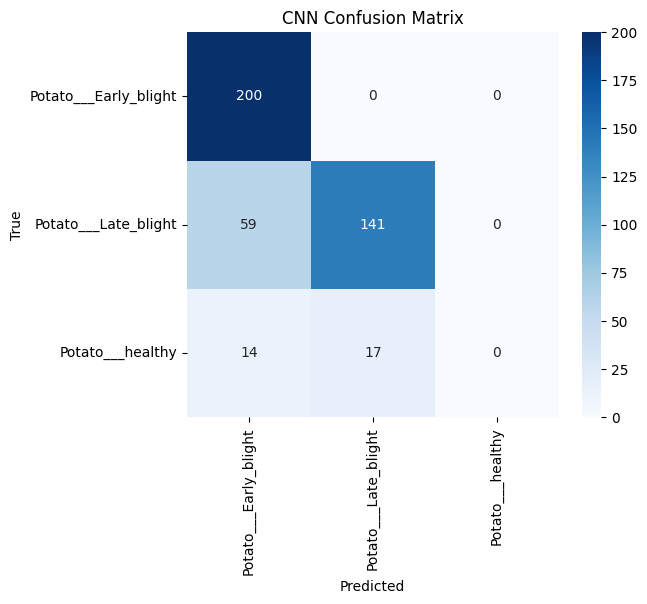

In [18]:
# STEP 14: Confusion Matrix (for CNN)
y_pred_cnn = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

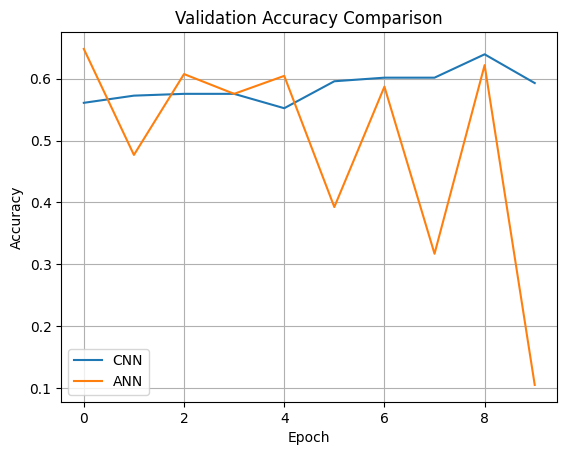

In [19]:


# STEP 15: Accuracy comparison plot
plt.plot(cnn_history.history['val_accuracy'], label='CNN')
plt.plot(ann_history.history['val_accuracy'], label='ANN')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
#using dropout

In [21]:
from tensorflow.keras import models, layers

image_size = 128
num_classes = 3

cnn_model = models.Sequential([
    layers.Input(shape=(image_size, image_size, 3)),

    # 1st Conv Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # 2nd Conv Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # 3rd Conv Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Fully Connected Layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [22]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.5104 - loss: 0.9989 - val_accuracy: 0.0000e+00 - val_loss: 1.9287
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.5574 - loss: 0.6735 - val_accuracy: 0.1744 - val_loss: 1.4001
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.6272 - loss: 0.6307 - val_accuracy: 0.6017 - val_loss: 2.4261
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.8691 - loss: 0.3367 - val_accuracy: 0.6308 - val_loss: 1.6319
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.8853 - loss: 0.3007 - val_accuracy: 0.6483 - val_loss: 4.6645
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9213 - loss: 0.2075 - val_accuracy: 0.6366 - val_loss: 3.2380
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.9349 - loss: 0.1977 - val_accuracy: 0.6395 - val_loss: 2.8410
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9494 - loss: 0.1480 - val_accurac

In [23]:
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5608 - loss: 2.8369
Test Accuracy: 0.75
Test Loss: 1.25


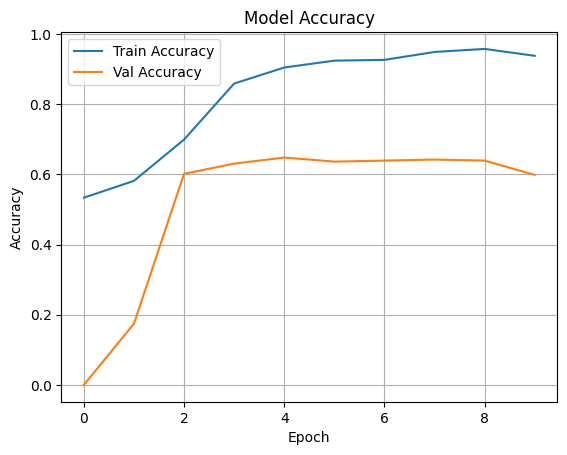

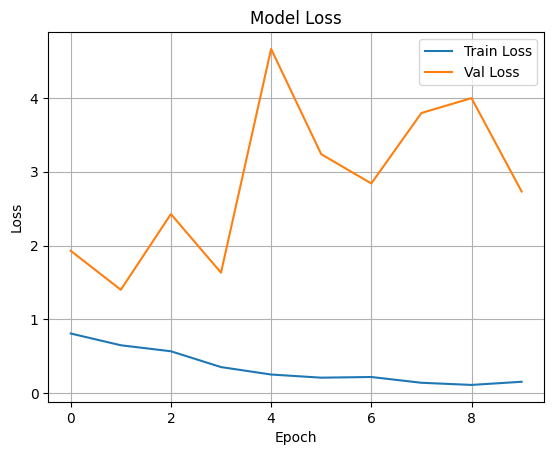

In [24]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.66      1.00      0.80       200
 Potato___Late_blight       0.97      0.62      0.76       200
     Potato___healthy       0.00      0.00      0.00        31

             accuracy                           0.75       431
            macro avg       0.54      0.54      0.52       431
         weighted avg       0.76      0.75      0.72       431



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


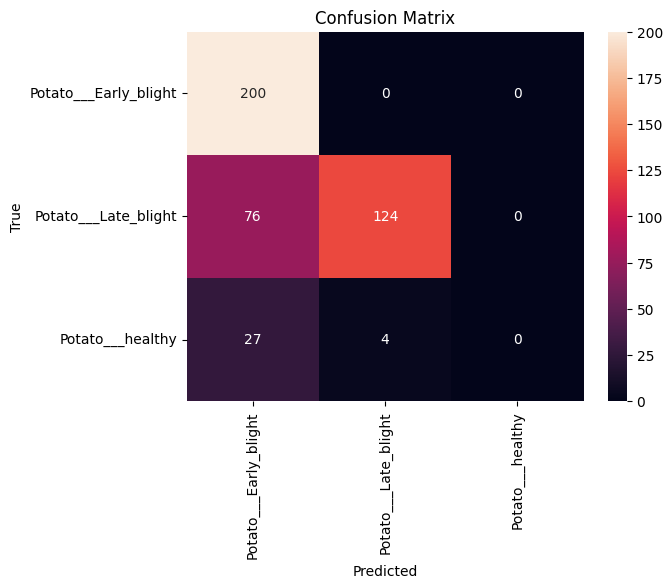

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = test_generator.classes
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


To_select_appropriate_optimizer

In [26]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [27]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [28]:
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(image_size, image_size, 3)))

    # Choose number of conv blocks
    for i in range(hp.Int('conv_blocks', 2, 4)):
        filters = hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32)
        model.add(layers.Conv2D(filters, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [29]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    directory='tuner_results',
    project_name='potato_tuning_v2'  # change name to avoid reloading old tuner
)

tuner.search(train_generator, validation_data=val_generator, epochs=10)


Trial 4 Complete [00h 01m 50s]
val_accuracy: 0.645348846912384

Best val_accuracy So Far: 0.645348846912384
Total elapsed time: 00h 07m 12s


In [31]:
best_model = tuner.get_best_models(num_models=1)[0]


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
_pred_probs = best_model.predict(val_generator)

# Convert probabilities to class labels
y_pred = np.argmax(_pred_probs, axis=1)

# True labels
y_true = val_generator.classes


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.00      0.00      0.00         0
 Potato___Late_blight       0.65      0.99      0.78       223
     Potato___healthy       0.00      0.00      0.00       121

             accuracy                           0.64       344
            macro avg       0.22      0.33      0.26       344
         weighted avg       0.42      0.64      0.51       344



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

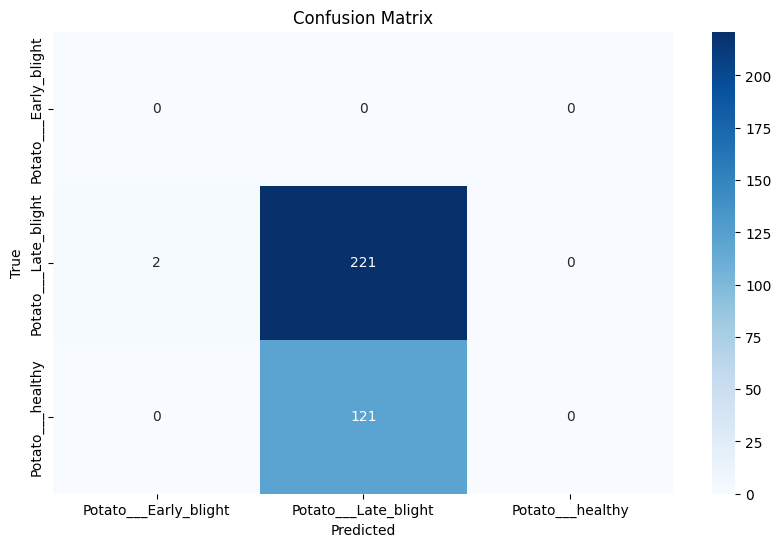

In [38]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



#Finding number of nodes in a layers

In [41]:
def build_model(hp):
    model = Sequential()
    model.add(layers.Input(shape=(image_size, image_size, 3)))

    # Choose number of convolutional blocks
    for i in range(hp.Int('conv_blocks', 2, 4)):
        filters = hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32)
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    # Tune the number of units in the Dense layer
    units = hp.Int('dense_units', min_value=8, max_value=128, step=8)
    model.add(layers.Dense(units=units, activation='relu'))

    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [42]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='potato_tuning_dense_units'
)

tuner.search(train_generator, validation_data=val_generator, epochs=10)


Trial 5 Complete [00h 01m 45s]
val_accuracy: 0.6482558250427246

Best val_accuracy So Far: 0.6482558250427246
Total elapsed time: 00h 09m 17s


In [43]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)


In [44]:
history = best_model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.5040 - loss: 0.8206 - val_accuracy: 0.0000e+00 - val_loss: 2.7879
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.5834 - loss: 0.7274 - val_accuracy: 0.0552 - val_loss: 2.0617
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.6634 - loss: 0.5836 - val_accuracy: 0.4186 - val_loss: 1.7214
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.8224 - loss: 0.4091 - val_accuracy: 0.5581 - val_loss: 3.7538
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.9127 - loss: 0.2502 - val_accuracy: 0.5262 - val_loss: 1.6431
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.8800 - loss: 0.3845 - val_accuracy: 0.4971 - val_loss: 6.2217
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.8889 - loss: 0.2863 - val_accuracy: 0.6105 - val_loss: 4.9228
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.9372 - loss: 0.1706 - val_accurac

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step
Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.00      0.00      0.00         0
 Potato___Late_blight       0.65      0.99      0.78       223
     Potato___healthy       0.00      0.00      0.00       121

             accuracy                           0.64       344
            macro avg       0.22      0.33      0.26       344
         weighted avg       0.42      0.64      0.51       344



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

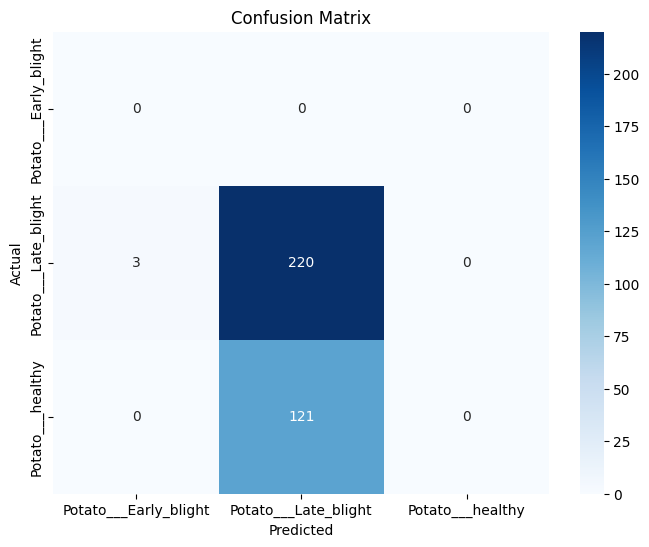

In [46]:
y_probs = best_model.predict(val_generator)
y_pred = np.argmax(y_probs, axis=1)

# True labels
y_true = val_generator.classes

# Class labels (optional but helpful)
class_labels = list(val_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()